<a href="https://colab.research.google.com/github/younan-marietherese/Intelligent-Claim-Approval-Engine/blob/main/MarieTherese_Younan_Intelligent_Claim_Approval_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Objective

Build an Intelligent Claim Approval Engine that predicts whether a medical claim should be approved before manual review, using historical claims and explainable ML.

# What this notebook includes

- Data Ingest and Cleaning

- Exploratory Data Analysis (EDA)

- Target and Leakage Control

- Feature Engineering

- Train/Valid Split

- Preprocessing Pipeline

- Modeling

- Threshold Tuning

- Explainability

- Artifacts and Inference

##Step 0: Environment Setup

Installed fixed versions of core libraries (pandas==2.2.2, numpy> = 2.0,<2.3, scikit-learn > =1.6,< 1.7, xgboost > =2.1.1, shap, category-encoders, openpyxl).

Imported main packages (numpy, pandas, sklearn, xgboost, shap) and printed their versions to confirm the environment.

In [ ]:
!pip -q install "pandas==2.2.2" \
  "numpy>=2.0,<2.3" \
  "scikit-learn>=1.6,<1.7" \
  "xgboost>=2.0,<2.1" \
  "category-encoders>=2.6,<2.7" \
  "shap>=0.46,<0.47" \
  "openpyxl>=3.1,<3.2"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.9/543.9 kB 16.7 MB/s eta 0:00:00


In [ ]:
!pip -q install "pandas==2.2.2" "numpy>=2.0,<2.3" "scikit-learn>=1.6,<1.7" "xgboost>=2.1.1"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 8.8 MB/s eta 0:00:00


In [ ]:
#Imports
import numpy as np, pandas as pd, sklearn, xgboost, shap
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("scikit-learn:", sklearn.__version__)


pandas: 2.2.2
numpy: 2.0.2
scikit-learn: 1.6.1


##Step 1: Load data

Uploaded the Excel file via Colab, inspected available sheet names, and loaded "Sheet1" into a pandas DataFrame. Displayed the shape and first 2 rows for a quick check.

In [ ]:
from google.colab import files

uploaded = files.upload()
FNAME = list(uploaded.keys())[0]

# Inspect sheet names
xls = pd.ExcelFile(FNAME)
xls.sheet_names


Saving Sample Data - Marie.xlsx to Sample Data - Marie.xlsx


['Sheet1']

In [ ]:
SHEET = "Sheet1"
df = pd.read_excel(FNAME, sheet_name=SHEET, engine="openpyxl")
df.shape, df.head(2)

((605291, 40),
   PAYMENT STATE COUNTRY INSURER   CLAIM NO CONDITION DATE OF ADMISSION  \
 0          PAID     LEB     ARP  114138602  ACCEPTED        2010-10-23   
 1          PAID     LEB     ARP  114138600  ACCEPTED        2010-10-21   
 
         FNOL  POLICY NUMBER       PP NO CLASS  ... CLOSING DATE  \
 0 2010-12-31       10727322  5001151989    AB  ...   2010-12-31   
 1 2010-12-31       10727324  5001166574    BB  ...   2010-12-31   
 
   MEDICAL REJECTIONS VARIANCE REJECTION TYPE BILLED TAX ACCEPTED TAX  \
 0                0.0                0.0  NaN       9.00         9.00   
 1                0.0                0.0  NaN       0.68         0.68   
 
    SRV DESC GROSS CLAIMED AMOUNT PAYABLE AMOUNT2    ADM TYPE  
 0       NaN                200.0           180.0  OUTPATIENT  
 1       NaN                 15.0            13.5  OUTPATIENT  
 
 [2 rows x 40 columns])

The dataset contains 605,291 rows and 40 columns, confirming a large-scale claims dataset. The preview shows key fields like PAYMENT STATE, COUNTRY, INSURER, CLAIM NO, CONDITION, and financial amounts (e.g., CLAIMED AMOUNT, PAYABLE AMOUNT2), indicating that both categorical and numerical features are available for model development.

##Step 2: Normalize Column Names amd Inspect Schema

Standardized headers to UPPER_SNAKE_CASE (spaces -> underscores, trimmed) and ran df.info() to confirm schema.

Now we have 40 columns with 8 datetime, 12 float, 4 int, and 16 object fields.

In [ ]:
import re
# Replace spaces with underscores, strip, uppercase
df.columns = [re.sub(r"\s+", "_", c.strip().upper()) for c in df.columns]

print("Columns:", df.columns.tolist())
df.info()


Columns: ['PAYMENT_STATE', 'COUNTRY', 'INSURER', 'CLAIM_NO', 'CONDITION', 'DATE_OF_ADMISSION', 'FNOL', 'POLICY_NUMBER', 'PP_NO', 'CLASS', 'COVER', 'DATE_OF_EXIT', 'CURRENCY', 'DATE_OF_INVOICE', 'DIAGNOSIS', 'DIAGNOSIS_DESCRIPTION', 'SERIAL', 'PROD', 'PROCESSING_DATE', 'CLAIM_RECEIVED_ON', 'CLAIMED_AMOUNT', 'SYSTEM_CLAIMED_AMOUNT', 'PAYABLE_AMOUNT', 'REJECTED_AMOUNT', 'PATIENT_SHARE', 'ENTRY_DATE', 'PRE-AUTHORIZED', 'HOSPITAL_CODE', 'SERVICE', 'DEDREASON', 'CLOSING_DATE', 'MEDICAL_REJECTIONS', 'VARIANCE_REJECTION', 'TYPE', 'BILLED_TAX', 'ACCEPTED_TAX', 'SRV_DESC', 'GROSS_CLAIMED_AMOUNT', 'PAYABLE_AMOUNT2', 'ADM_TYPE']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605291 entries, 0 to 605290
Data columns (total 40 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   PAYMENT_STATE          605291 non-null  object        
 1   COUNTRY                605291 non-null  object        
 2   INSURER            

Naming is consistent and code-friendly. Schema check highlights key gaps to handle later (e.g., heavy nulls in TYPE (531/605k non-null), SRV_DESC (245k), DEDREASON (500k), and some partial nulls like PROCESSING_DATE, taxes).

##Step 3: Assign column Types (dates, numeric, categorical, IDs)

We convert date fields to datetime, numeric fields to floats/ints, and categorical fields to strings. IDs are kept as strings so they aren't mistakenly treated as features.

In [ ]:
DATE_COLS = ['DATE_OF_ADMISSION','DATE_OF_EXIT','DATE_OF_INVOICE','PROCESSING_DATE',
             'CLAIM_RECEIVED_ON','ENTRY_DATE','CLOSING_DATE']
NUM_RAW   = ['CLAIMED_AMOUNT','SYSTEM_CLAIMED_AMOUNT','PAYABLE_AMOUNT','REJECTED_AMOUNT',
             'PATIENT_SHARE','BILLED_TAX','ACCEPTED_TAX','GROSS_CLAIMED_AMOUNT',
             'PAYABLE_AMOUNT_2','HOSPITAL_CODE','MEDICAL_REJECTIONS','VARIANCE_REJECTION']
CAT_RAW   = ['PAYMENT_STATE','COUNTRY','INSURER','CONDITION','CLASS','COVER','CURRENCY',
             'DIAGNOSIS','DIAGNOSIS_DESCRIPTION','PROD','SERVICE','DEDREASON',
             'ADMISSION_TYPE','PRE-AUTHORIZED','SERVICE_DESC','TYPE']
ID_LIKE   = ['CLAIM_NO','POLICY_NUMBER','PP_NO','SERIAL']

for c in DATE_COLS:
    if c in df.columns: df[c] = pd.to_datetime(df[c], errors='coerce')
for c in NUM_RAW:
    if c in df.columns: df[c] = pd.to_numeric(df[c], errors='coerce')
for c in CAT_RAW:
    if c in df.columns: df[c] = df[c].astype('string')
for c in ID_LIKE:
    if c in df.columns:
        try: df[c] = df[c].astype('Int64').astype('string')
        except: df[c] = df[c].astype('string')

df[DATE_COLS].head(2)

,DATE_OF_ADMISSION,DATE_OF_EXIT,DATE_OF_INVOICE,PROCESSING_DATE,CLAIM_RECEIVED_ON,ENTRY_DATE,CLOSING_DATE
0,2010-10-23,2010-10-23,2010-10-23,2018-12-31,2010-11-19,2010-12-31 15:03:29,2010-12-31
1,2010-10-21,2010-10-21,2010-10-21,2018-12-31,2010-11-19,2010-12-31 15:03:29,2010-12-31


Data types are now consistent and ready for feature engineering and modeling.

##Step 4: Handle Duplicates and Missing Values

We remove duplicate rows and calculate missing values per column. Very high-missing columns (like TYPE) can be dropped, since they provide little information.

In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer

#Count and remove duplicates
dups = int(df.duplicated().sum())
if dups:
    df = df.drop_duplicates().reset_index(drop=True)
print("Removed duplicate rows:", dups)

#Count missing values per column
missing_pct = (df.isna().mean()*100).sort_values(ascending=False)
print("\nMissing values (% of rows) per column:\n", missing_pct.head(12))


Removed duplicate rows: 16

Missing values (% of rows) per column:
 TYPE                     99.912271
SRV_DESC                 59.511462
DEDREASON                17.327331
BILLED_TAX                1.476849
ACCEPTED_TAX              1.476519
PROCESSING_DATE           0.865887
PATIENT_SHARE             0.300690
SYSTEM_CLAIMED_AMOUNT     0.032878
DATE_OF_EXIT              0.030069
HOSPITAL_CODE             0.007435
DIAGNOSIS                 0.000661
DIAGNOSIS_DESCRIPTION     0.000661
dtype: float64


Most fields are complete; key gaps are TYPE (99.9%), SRV_DESC (59.5%), and DEDREASON (17.3%), which we'll impute or exclude in features as needed.

###Step 4.1 : Set Missingness Threshold

Choose THRESH_COL = 0.60 to flag ultra-sparse columns.

In [ ]:
THRESH_COL = 0.60

Balances data retention with quality; avoids dropping SRV_DESC (59.51%).

###Step 4.2: Drop High-Missing Columns


Dropped columns exceeding 60% missing -> ['TYPE'].

In [ ]:
to_drop = [c for c in df.columns if df[c].isna().mean() > THRESH_COL]
if to_drop:
    df = df.drop(columns=to_drop)
    print("Dropped high-missing columns:", to_drop)

Dropped high-missing columns: ['TYPE']


Removes low-value noise and simplifies downstream processing.

###Step 4.3: Re-identify Column Types

Split columns into date_cols, num_cols, and cat_cols.

In [ ]:
date_cols = df.select_dtypes(include=["datetime64[ns]"]).columns
num_cols  = df.select_dtypes(include=[np.number]).columns
cat_cols  = df.columns.difference(num_cols.union(date_cols))

Sets up targeted imputation per data type.

###Step 4.4: Impute Numerics

Filled numeric NaNs with median.

In [ ]:
from sklearn.impute import SimpleImputer

if len(num_cols):
    num_imputer = SimpleImputer(strategy="median")
    df[num_cols] = num_imputer.fit_transform(df[num_cols])

Robust to outliers; keeps distributions stable.

###Step 4.5: Impute Categoricals

Standardized missing markers then filled with most_frequent.

In [ ]:
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

#Cast to plain object so NA becomes allowable np.nan
cats = df[cat_cols].astype('object')
#Unify all missing markers to np.nan
cats = cats.where(pd.notna(cats), np.nan)

cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(cats)

Preserves common categories; avoids creating rare “Unknowns”.

###Step 4.6: Sanity Check

Verified remaining missing cells = 5,423, concentrated in dates (PROCESSING_DATE ≈ 0.87%, DATE_OF_EXIT = 0.03%).

In [ ]:
total_na = int(df.isna().sum().sum())
print("Remaining missing cells:", total_na)
if total_na:
    print(df.isna().mean().sort_values(ascending=False).head(10))

Remaining missing cells: 5423
PROCESSING_DATE      0.008659
DATE_OF_EXIT         0.000301
PAYMENT_STATE        0.000000
CLAIM_NO             0.000000
CONDITION            0.000000
COUNTRY              0.000000
INSURER              0.000000
FNOL                 0.000000
DATE_OF_ADMISSION    0.000000
CLASS                0.000000
dtype: float64


Residual NaNs are expected since we don't impute dates; modeling features remain complete.

##Step 5: EDA visuals

###5.1: Select amount columns

This step defines the numeric amount columns we want to analyze.
It ensures that all following steps run only on these relevant financial features.

In [ ]:
# Pick amount-like columns
candidate_amt_cols = [
    'CLAIMED_AMOUNT',
    'SYSTEM_CLAIMED_AMOUNT',
    'PATIENT_SHARE',
    'BILLED_TAX',
    'ACCEPTED_TAX',
    'PAYABLE_AMOUNT',
    'REJECTED_AMOUNT',
    'GROSS_CLAIMED_AMOUNT',
    'PAYABLE_AMOUNT2'
]

# Keep only those that exist in df
amt_cols = [c for c in candidate_amt_cols if c in df.columns]

#Ensure amounts are numeric
for c in amt_cols:
    df[c] = (
        df[c]
        .astype(str)
        .str.replace(',', '', regex=False)
        .str.replace('\u2013', '-', regex=False)
        .str.replace('—', '-', regex=False)
    )
    df[c] = pd.to_numeric(df[c], errors='coerce')

print("Amount columns used:", amt_cols)
print(df[amt_cols].dtypes)

Amount columns used: ['CLAIMED_AMOUNT', 'SYSTEM_CLAIMED_AMOUNT', 'PATIENT_SHARE', 'BILLED_TAX', 'ACCEPTED_TAX', 'PAYABLE_AMOUNT', 'REJECTED_AMOUNT', 'GROSS_CLAIMED_AMOUNT', 'PAYABLE_AMOUNT2']
CLAIMED_AMOUNT           float64
SYSTEM_CLAIMED_AMOUNT    float64
PATIENT_SHARE            float64
BILLED_TAX               float64
ACCEPTED_TAX             float64
PAYABLE_AMOUNT           float64
REJECTED_AMOUNT          float64
GROSS_CLAIMED_AMOUNT     float64
PAYABLE_AMOUNT2          float64
dtype: object


The main financial columns were correctly identified, and all are in numeric format (float64), making them ready for EDA and modeling.

###5.2: Summary statistics

We compute descriptive statistics (mean, median, percentiles) for the selected columns.
This gives a quick overview of central tendency, spread, and missing percentages.

In [ ]:
display(
    df[amt_cols].describe(percentiles=[.25, .5, .75, .95, .99]).T
    .rename(columns={'50%':'median'})
    .assign(missing_pct = df[amt_cols].isna().mean().mul(100).round(2))
)

,count,mean,std,min,25%,median,75%,95%,99%,max,missing_pct
CLAIMED_AMOUNT,605275.0,161.458830,1799.817004,-41167.84,25.00,48.00,105.00,379.013,1410.6338,615506.71,0.0
SYSTEM_CLAIMED_AMOUNT,605275.0,32.601474,321.696168,0.00,1.81,10.50,25.00,110.000,274.8286,127300.47,0.0
PATIENT_SHARE,605275.0,13.564684,17.485709,0.00,3.60,7.50,16.00,50.400,86.0000,2000.00,0.0
BILLED_TAX,605275.0,5.390169,69.526753,0.00,0.00,0.96,2.53,13.640,55.8200,17479.76,0.0
ACCEPTED_TAX,605275.0,4.865875,63.283806,-500.00,0.00,0.70,2.14,12.160,50.9900,16238.70,0.0
PAYABLE_AMOUNT,605275.0,146.413284,1632.204459,-176515.80,20.00,41.85,96.00,341.659,1305.8808,409239.47,0.0
REJECTED_AMOUNT,605275.0,15.045546,452.388933,-62.00,0.00,0.00,3.00,42.000,186.0000,212827.00,0.0
GROSS_CLAIMED_AMOUNT,605275.0,194.056851,2010.357955,-41167.84,30.00,60.00,130.00,476.250,1680.0000,618266.61,0.0
PAYABLE_AMOUNT2,605275.0,132.871152,1631.578904,-176515.80,15.62,32.79,78.00,299.250,1263.1390,409239.47,0.0


Distributions are highly skewed with extreme outliers (e.g., negative amounts, very large maximums). Medians (e.g., CLAIMED_AMOUNT = 48) are far lower than means, confirming long right tails.

###5.3: Skewness and kurtosis

We calculate skewness (asymmetry) and kurtosis (tail heaviness) for each column.
This helps detect whether values are normally distributed or skewed with long tails.

In [ ]:
sk_table = pd.DataFrame({
    'skew': df[amt_cols].skew(numeric_only=True),
    'kurtosis': df[amt_cols].kurt(numeric_only=True)
}).round(3)
display(sk_table)

,skew,kurtosis
CLAIMED_AMOUNT,137.846,33840.762
SYSTEM_CLAIMED_AMOUNT,174.097,51796.330
PATIENT_SHARE,5.178,290.560
BILLED_TAX,109.759,19861.892
ACCEPTED_TAX,101.126,17163.722
PAYABLE_AMOUNT,100.030,18861.299
REJECTED_AMOUNT,312.059,127068.591
GROSS_CLAIMED_AMOUNT,128.030,27954.747
PAYABLE_AMOUNT2,100.168,18893.551


Nearly all financial fields show extreme skew and heavy tails, confirming the presence of large outliers and non-normal distributions.

###5.4: Outlier counts

Flagged values above the 99.5th percentile in each amount column.

In [ ]:
outlier_info = []
for c in amt_cols:
    s = df[c].dropna().astype(float)
    if s.empty:
        outlier_info.append((c, 0, 0.0))
        continue
    thr = np.nanpercentile(s, 99.5)
    n_out = int((s > thr).sum())
    pct_out = 100 * n_out / len(s)
    outlier_info.append((c, n_out, round(pct_out, 3)))
outlier_df = pd.DataFrame(outlier_info, columns=['column','n_above_99_5','pct_above_99_5'])
display(outlier_df)

,column,n_above_99_5,pct_above_99_5
0,CLAIMED_AMOUNT,3027,0.500
1,SYSTEM_CLAIMED_AMOUNT,3027,0.500
2,PATIENT_SHARE,3015,0.498
3,BILLED_TAX,3026,0.500
4,ACCEPTED_TAX,3027,0.500
5,PAYABLE_AMOUNT,3027,0.500
6,REJECTED_AMOUNT,3024,0.500
7,GROSS_CLAIMED_AMOUNT,3027,0.500
8,PAYABLE_AMOUNT2,3027,0.500


Around 0.5% of records per column are extreme outliers, consistent across all financial fields.

##5.5: Per-column histograms

We plot histograms for each column clipped at the 99.5th percentile.
The y-axis is set to log scale to make rare but extreme values visible.

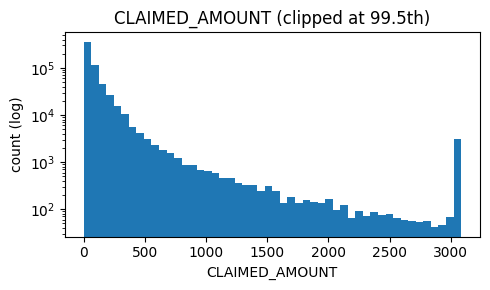

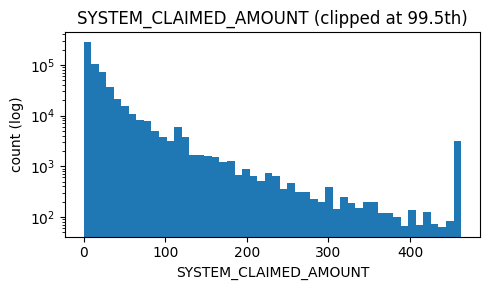

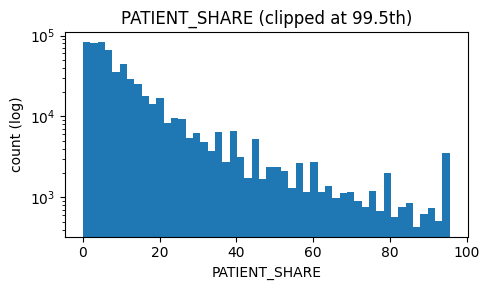

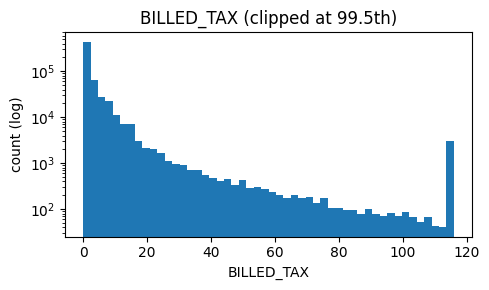

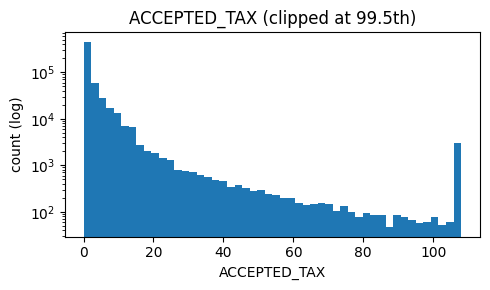

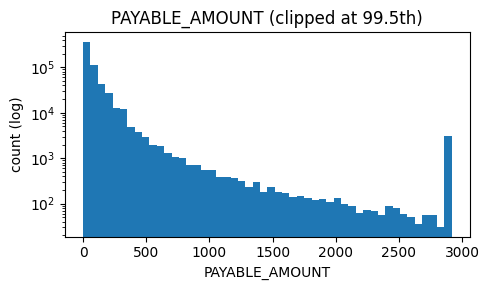

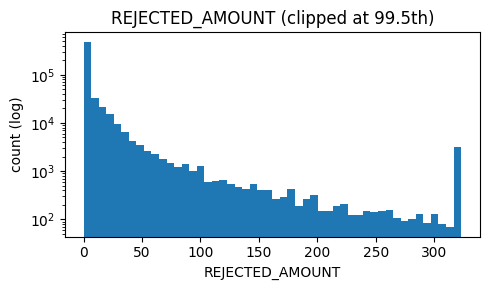

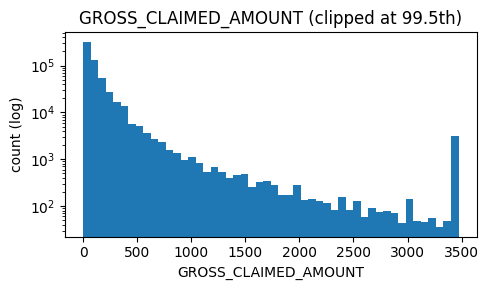

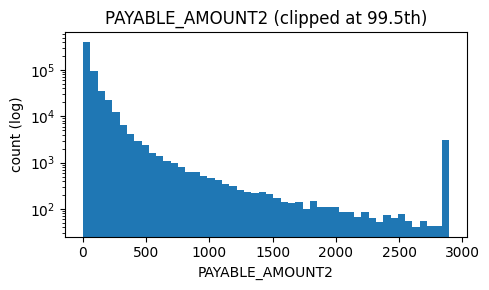

In [ ]:
import matplotlib.pyplot as plt

def clipped(s, q=99.5):
    v = s.dropna().astype(float)
    if v.empty:
        return v
    lim = np.nanpercentile(v, q)
    return np.clip(v, 0, lim)

for c in amt_cols:
    v = clipped(df[c], q=99.5)
    plt.figure(figsize=(5,3))
    plt.hist(v + 1e-9, bins=50)
    plt.yscale('log')
    plt.title(f"{c} (clipped at 99.5th)")
    plt.xlabel(c); plt.ylabel("count (log)")
    plt.tight_layout()
    plt.show()

All 9 amount variables show heavily right-skewed distributions, with most values concentrated at the low end and long tails stretching to extreme amounts. The log-scaled histograms confirm that extreme outliers exist, but clipping at the 99.5th percentile makes the core distribution patterns clearer.

###5.6: Overlayed histogram

We plot all amount columns on the same histogram.
This allows us to compare ranges and distributions in one figure.

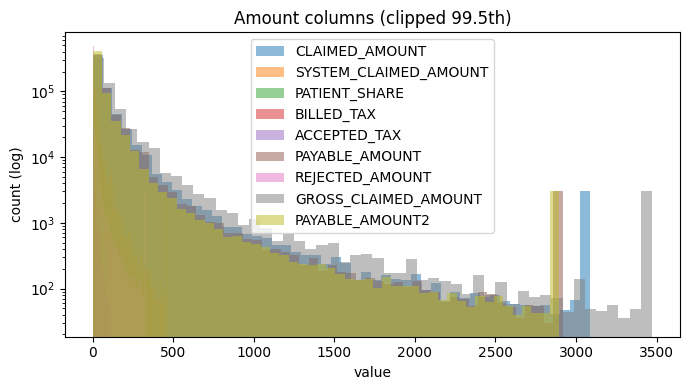

In [ ]:
plt.figure(figsize=(7,4))
for c in amt_cols:
    v = clipped(df[c], q=99.5)
    if len(v):
        plt.hist(v, bins=50, alpha=0.5, label=c)
plt.yscale('log'); plt.legend()
plt.title("Amount columns (clipped 99.5th)")
plt.xlabel("value"); plt.ylabel("count (log)")
plt.tight_layout()
plt.show()

The overlayed histogram shows that all amount columns follow a similar right-skewed pattern, with most values clustered at the low end. Some variables like CLAIMED_AMOUNT, PAYABLE_AMOUNT, and GROSS_CLAIMED_AMOUNT extend much further, dominating the upper range compared to the others.

###5.7: Boxplots

We create boxplots for each column with whiskers between the 1st and 99th percentiles.
This visualizes medians, interquartile ranges, and potential outliers.

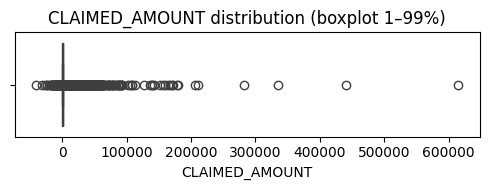

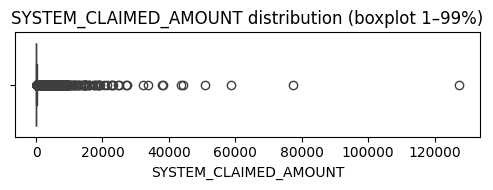

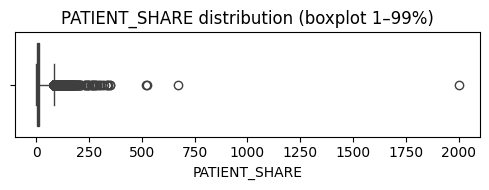

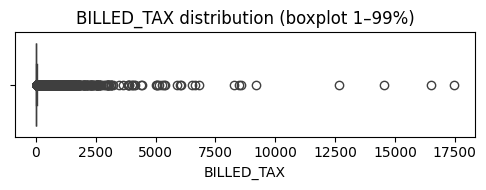

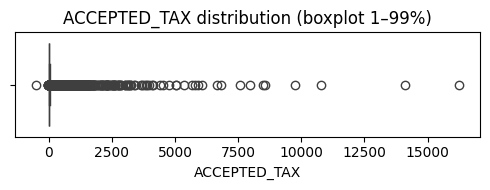

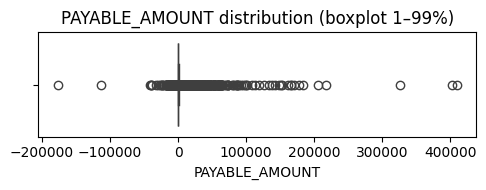

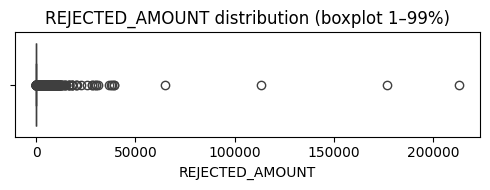

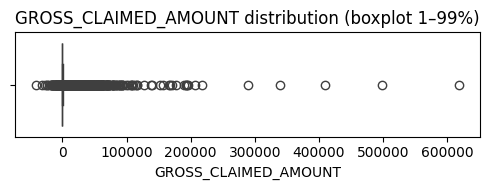

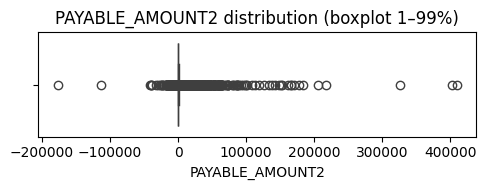

In [ ]:
import seaborn as sns
for c in amt_cols:
    plt.figure(figsize=(5,2))
    sns.boxplot(x=df[c], whis=[1,99])
    plt.title(f"{c} distribution (boxplot 1–99%)")
    plt.tight_layout()
    plt.show()

The boxplots show that nearly all amount variables contain extreme outliers far beyond the bulk of data, with very compressed interquartile ranges. This reinforces the earlier findings of skewness and highlights the need for scaling, clipping, or log-transformation before modeling.

###5.8: Correlation Heatmap

We calculate Spearman correlations between amount columns.
The heatmap helps visualize monotonic relationships, even if distributions are skewed.

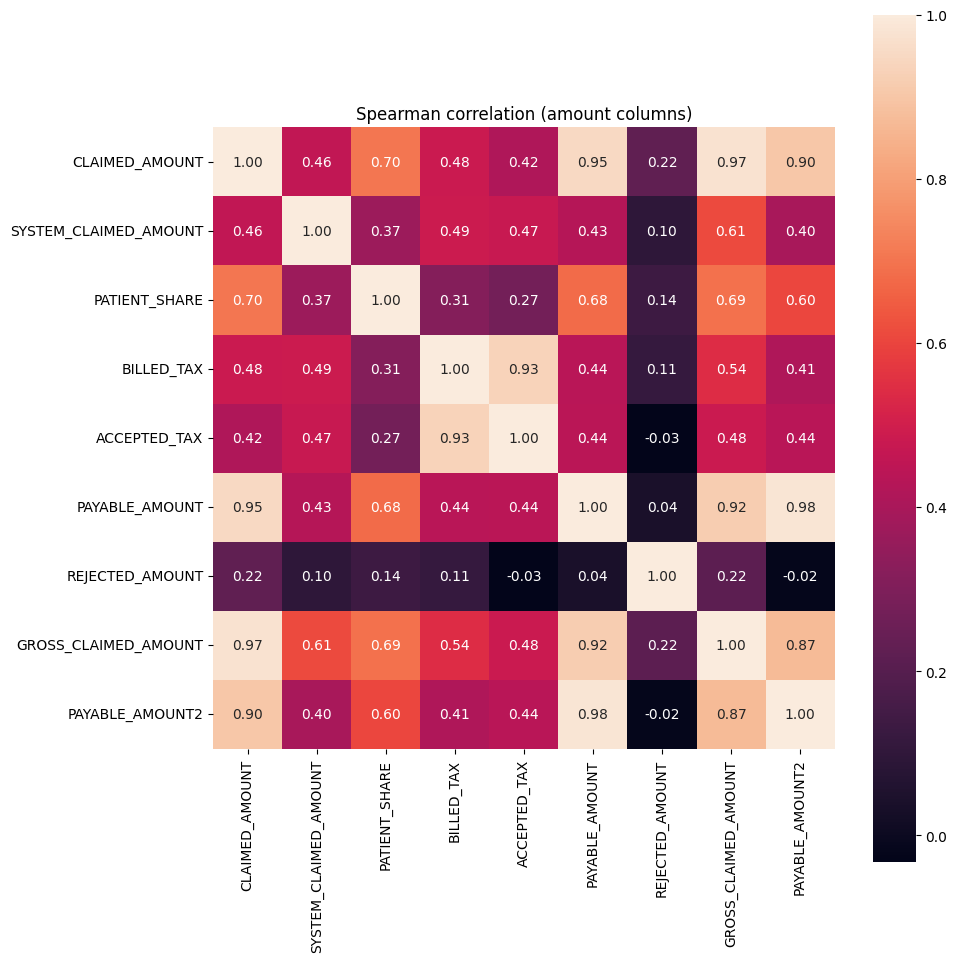

In [ ]:
if len(amt_cols) >= 2:
    corr = df[amt_cols].corr(method='spearman')
    plt.figure(figsize=(0.9*len(amt_cols)+2, 0.9*len(amt_cols)+2))
    sns.heatmap(corr, annot=True, fmt=".2f", square=True, cbar=True)
    plt.title("Spearman correlation (amount columns)")
    plt.tight_layout()
    plt.show()

The heatmap shows very strong correlations between CLAIMED_AMOUNT, PAYABLE_AMOUNT, GROSS_CLAIMED_AMOUNT, and PAYABLE_AMOUNT2 (p > 0.9), suggesting they capture overlapping information. In contrast, REJECTED_AMOUNT and SYSTEM_CLAIMED_AMOUNT have weak correlations with most others, meaning they may add unique signals.

##Step 6: Define Target and Prevent Leakage

###Step 6.1 (Label Creation): Construct Approval Label

Created the target APPROVED = 1 when PAYABLE_AMOUNT > 0 and REJECTED_AMOUNT = 0, else 0.

In [ ]:
df['APPROVED'] = ((df.get('PAYABLE_AMOUNT',0).fillna(0) > 0) &
                  (df.get('REJECTED_AMOUNT',0).fillna(0) == 0)).astype(int)
df['APPROVED'].value_counts(normalize=True)

,proportion
APPROVED,
1,0.644122
0,0.355878


Class balance is 64.4% approved vs 35.6% rejected, giving a moderately imbalanced dataset suitable for classification.

###Step 6.2: (Leakage Guard): Identify Outcome-Linked Columns to Exclude

Defined a set of columns (LEAK) that directly reveal outcomes (e.g., payment state, payable/rejected amounts, rejection codes, closing/processing dates).

In [ ]:
LEAK = {'PAYMENT_STATE','PAYABLE_AMOUNT','PAYABLE_AMOUNT_2','REJECTED_AMOUNT',
        'MEDICAL_REJECTIONS','VARIANCE_REJECTION','DEDREASON','CLOSING_DATE','PROCESSING_DATE'}

Excluding these prevents data leakage, ensuring the model only learns from information available at decision time.

##Step 7: Feature Engineering (Time Gaps and Ratios)

Built time-gap features (DAYS_*) with caps and ratio features (PATIENT_SHARE_PCT, TAX_ACCEPT_RATIO, SYSTEM_TO_CLAIMED_RATIO).

In [ ]:
# Date gaps
df['DAYS_ADMISSION_TO_EXIT']    = (df['DATE_OF_EXIT']     - df['DATE_OF_ADMISSION']).dt.days.astype('float')
df['DAYS_ADMISSION_TO_INVOICE'] = (df['DATE_OF_INVOICE']  - df['DATE_OF_ADMISSION']).dt.days.astype('float')
df['DAYS_INVOICE_TO_RECEIVED']  = (df['CLAIM_RECEIVED_ON']- df['DATE_OF_INVOICE']).dt.days.astype('float')

for c, up in [('DAYS_ADMISSION_TO_EXIT', 365), ('DAYS_ADMISSION_TO_INVOICE', 180), ('DAYS_INVOICE_TO_RECEIVED', 365)]:
    if c in df.columns: df[c] = df[c].clip(lower=0, upper=up)

# Ratios
eps = 1e-9
if {'PATIENT_SHARE','CLAIMED_AMOUNT'}.issubset(df.columns):
    df['PATIENT_SHARE_PCT'] = (df['PATIENT_SHARE']/(df['CLAIMED_AMOUNT']+eps)).clip(0, 5.0)
if {'ACCEPTED_TAX','BILLED_TAX'}.issubset(df.columns):
    df['TAX_ACCEPT_RATIO'] = (df['ACCEPTED_TAX']/(df['BILLED_TAX']+eps)).fillna(0).clip(0, 2.0)
if {'SYSTEM_CLAIMED_AMOUNT','CLAIMED_AMOUNT'}.issubset(df.columns):
    df['SYSTEM_TO_CLAIMED_RATIO'] = (df['SYSTEM_CLAIMED_AMOUNT']/(df['CLAIMED_AMOUNT']+eps)).clip(0, 5.0)

df[['DAYS_INVOICE_TO_RECEIVED','PATIENT_SHARE_PCT','TAX_ACCEPT_RATIO','SYSTEM_TO_CLAIMED_RATIO']].describe().T

,count,mean,std,min,25%,50%,75%,max
DAYS_INVOICE_TO_RECEIVED,605275.0,44.489929,22.445953,0.0,30.000000,41.000000,54.000000,298.0
PATIENT_SHARE_PCT,605275.0,0.176451,0.131761,0.0,0.199860,0.200000,0.200000,5.0
TAX_ACCEPT_RATIO,605275.0,0.553766,0.467844,0.0,0.000000,0.800000,1.000000,2.0
SYSTEM_TO_CLAIMED_RATIO,605275.0,0.312179,0.334720,0.0,0.075296,0.111952,0.538462,5.0


Latency and consistency signals are now explicit.

DAYS_INVOICE_TO_RECEIVED median = 41 days; PATIENT_SHARE_PCT clusters = 0.20; TAX_ACCEPT_RATIO median = 0.80 (75% up to 1.0); SYSTEM_TO_CLAIMED_RATIO median = 0.112 with a wide tail.

##Step 8: Select Final Features

Built the feature list from categoricals, numeric bases, and available text fields, then removed IDs and leak columns.

In [ ]:
# Text (handle either SRV_DESC or SERVICE_DESC)
TEXT_COLS = [c for c in ['DIAGNOSIS_DESCRIPTION','SRV_DESC','SERVICE_DESC'] if c in df.columns]

# Categorical (handle ADM_TYPE vs ADMISSION_TYPE)
CAT_CANDIDATES = ['COUNTRY','INSURER','CONDITION','CLASS','COVER','CURRENCY',
                  'ADM_TYPE','ADMISSION_TYPE','SERVICE','PRE-AUTHORIZED','PROD']
CAT_COLS = [c for c in CAT_CANDIDATES if c in df.columns]

# Numeric base
NUM_BASE = ['CLAIMED_AMOUNT','SYSTEM_CLAIMED_AMOUNT','PATIENT_SHARE',
            'BILLED_TAX','ACCEPTED_TAX','GROSS_CLAIMED_AMOUNT',
            'DAYS_ADMISSION_TO_EXIT','DAYS_ADMISSION_TO_INVOICE','DAYS_INVOICE_TO_RECEIVED',
            'PATIENT_SHARE_PCT','TAX_ACCEPT_RATIO','SYSTEM_TO_CLAIMED_RATIO']

# Add engineered amount features
ENGINEERED = [c for c in df.columns if any(
    c.endswith(suf) for suf in ('_CLIP','_LOG1P','_NEG_FLAG','_ZERO_FLAG')
)]
NUM_COLS = [c for c in (NUM_BASE + ENGINEERED) if c in df.columns]

# IDs to exclude
ID_LIKE = [c for c in ['CLAIM_NO','POLICY_NUMBER','PP_NO','SERIAL','HOSPITAL_CODE'] if c in df.columns]

# Final features
BASE_FEATURES = [c for c in (CAT_COLS + NUM_COLS + TEXT_COLS) if c not in LEAK and c not in ID_LIKE]

len(BASE_FEATURES), BASE_FEATURES[:10]

(24,
 ['COUNTRY',
  'INSURER',
  'CONDITION',
  'CLASS',
  'COVER',
  'CURRENCY',
  'ADM_TYPE',
  'SERVICE',
  'PRE-AUTHORIZED',
  'PROD'])

A total of 24 features were selected, covering categorical variables like country, insurer, service type, and product, along with numeric and text-based fields. This balanced feature set combines claim metadata, amounts, and descriptions while excluding IDs and leak-prone columns.

##Step 9: Train/Valid Split - Time-based Split

We split data into training and validation sets based on time (claims received date). This mimics real-world deployment where future claims shouldn't influence past training. So we split by CLAIM_RECEIVED_ON at the 80th percentile into train vs. vakidation.

In [ ]:
cut = df['CLAIM_RECEIVED_ON'].quantile(0.8)
train_idx = df['CLAIM_RECEIVED_ON'] <= cut
valid_idx = df['CLAIM_RECEIVED_ON'] > cut

X_train, X_valid = df.loc[train_idx, BASE_FEATURES], df.loc[valid_idx, BASE_FEATURES]
y_train, y_valid = df.loc[train_idx, 'APPROVED'], df.loc[valid_idx, 'APPROVED']
X_train.shape, X_valid.shape, float(y_train.mean()), float(y_valid.mean())

((495066, 24), (110209, 24), 0.647646980402613, 0.6282880708472085)

The dataset was split into 495k training rows and 110k validation rows, each with 24 features. Approval rates are close (64.8% train vs. 62.8% valid), showing a stable distribution across time.

###Outlier Capping and Derived Amount Features

We created clipped, log-transformed, and indicator versions of the key amount fields to reduce the impact of extreme values while keeping useful patterns. These features improve model stability and capture signals from negative or zero claims.

In [ ]:
amt_for_feats = [c for c in [
    'CLAIMED_AMOUNT','SYSTEM_CLAIMED_AMOUNT','PATIENT_SHARE',
    'BILLED_TAX','ACCEPTED_TAX','GROSS_CLAIMED_AMOUNT'
] if c in X_train.columns]

# fit clip thresholds on TRAIN only
clip_stats = {c: np.nanpercentile(X_train[c].astype(float), 99.5) for c in amt_for_feats}

# helper to apply features
def add_amount_features(df_like, cols, clip_stats):
    for c in cols:
        s  = df_like[c].astype(float)
        hi = clip_stats[c]
        df_like[f"{c}_CLIP"]      = np.clip(s, None, hi)
        df_like[f"{c}_NEG_FLAG"]  = (s < 0).astype('uint8')
        df_like[f"{c}_ZERO_FLAG"] = (s == 0).astype('uint8')
        df_like[f"{c}_LOG1P"]     = np.log1p(np.clip(s, 0, hi))
    return df_like

# apply to each split
X_train = add_amount_features(X_train, amt_for_feats, clip_stats)
X_valid = add_amount_features(X_valid, amt_for_feats, clip_stats)

# update numeric feature list to include the new columns
extra_num = []
for c in amt_for_feats:
    extra_num += [f"{c}_CLIP", f"{c}_LOG1P", f"{c}_NEG_FLAG", f"{c}_ZERO_FLAG"]

NUM_COLS = [c for c in NUM_COLS if c in X_train.columns] + extra_num

# Rebuild BASE_FEATURES so the ColumnTransformer sees the new columns
BASE_FEATURES = [c for c in (CAT_COLS + NUM_COLS + TEXT_COLS) if c not in LEAK and c not in ID_LIKE]
X_train, X_valid = X_train[BASE_FEATURES], X_valid[BASE_FEATURES]

We cap extreme values and add sign/zero flags; log1p makes ranges steadier. Caps are fit on the training set to avoid leakage, so features stay consistent on validation and inference.

In [ ]:
#pickable flattener
import numpy as np

def flatten_1d(X):
    return np.asarray(X).ravel()

##Step 10: Preprocessing (impute, target-encode, TF-IDF)

We handled missing values in numeric and categorical fields through imputation, encoded categorical variables with OneHotEncoder to make them machine-readable, and converted text descriptions into numeric vectors with TF-IDF. Together, these steps transformed raw mixed-type data into a unified numeric feature space ready for modeling.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

transformers = []

# Numeric
if NUM_COLS:
    transformers.append(('num', SimpleImputer(strategy='median'), NUM_COLS))

# Categorical
if CAT_COLS:
    transformers.append(('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='infrequent_if_exist',
                              min_frequency=50,
                              sparse_output=True))
    ]), CAT_COLS))

# Text: impute '' -> **flatten_1d (named)** -> TF-IDF
for tcol in TEXT_COLS:
    transformers.append((
        f'text_{tcol}',
        Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='')),
            ('flatten', FunctionTransformer(flatten_1d, accept_sparse=False)),
            ('tfidf', TfidfVectorizer(max_features=2000, ngram_range=(1,2)))
        ]),
        [tcol]
    ))

pre = ColumnTransformer(
    transformers=transformers,
    remainder='drop',
    verbose_feature_names_out=False
)

In [ ]:
pre.fit(X_train, y_train)
Xt_train = pre.transform(X_train)
Xt_valid = pre.transform(X_valid)
print("Shapes:", Xt_train.shape, Xt_valid.shape)

Shapes: (495066, 4082) (110209, 4082)


Produced sparse model-ready matrices with aligned features: Xt_train (495,066 x 4,082) and Xt_valid (110,209 x 4,082).

##Step 11: Model Training (XGBoost) and Calibration

Trained an XGBoost classifier, then applied sigmoid calibration on the validation split; wrapped preprocessing + model in a pipeline.

In [ ]:
#model training
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline as SkPipe
from sklearn.calibration import CalibratedClassifierCV

base = XGBClassifier(
    n_estimators=350, max_depth=6, learning_rate=0.06,
    subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
    eval_metric='logloss', random_state=42, tree_method='hist', n_jobs=-1
)

pipe_base = SkPipe([('pre', pre), ('model', base)])
pipe_base.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['CLAIMED_AMOUNT',
                                                   'SYSTEM_CLAIMED_AMOUNT',
                                                   'PATIENT_SHARE',
                                                   'BILLED_TAX', 'ACCEPTED_TAX',
                                                   'GROSS_CLAIMED_AMOUNT',
                                                   'DAYS_ADMISSION_TO_EXIT',
                                                   'DAYS_ADMISSION_TO_INVOICE',
                                                   'DAYS_INVOICE_TO_RECEIVED',
                                                   'PATIENT_SHARE_PCT',
                                                   'TAX_ACCEPT_RATIO',
                                                   'SYSTEM_TO_CLAIMED_RATIO',
                                                   '...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.06,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=350, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [ ]:
#calibration on validation set
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline as SkPipe
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

Xv_trans = pipe_base.named_steps['pre'].transform(X_valid)
cal = CalibratedClassifierCV(base, cv='prefit', method='sigmoid')
cal.fit(Xv_trans, y_valid)

clf = SkPipe([('pre', pre), ('model', cal)])
proba_valid = clf.predict_proba(X_valid)[:, 1]

print("ROC-AUC:", round(roc_auc_score(y_valid, proba_valid), 4))
print("PR-AUC :", round(average_precision_score(y_valid, proba_valid), 4))
print("Brier  :", round(brier_score_loss(y_valid, proba_valid), 4))

/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


ROC-AUC: 0.9779
PR-AUC : 0.9867
Brier  : 0.0582


Strong validation performance: ROC-AUC 0.9779, PR-AUC 0.9867, Brier 0.0582, with well-calibrated probabilities for downstream thresholding.

##Step 12: Threshold Tuning

Evaluated precision/recall/specificity at candidate cutoffs (0.2-0.6) using validation probabilities.

In [ ]:
from sklearn.metrics import precision_recall_curve, confusion_matrix
prec, rec, thr = precision_recall_curve(y_valid, proba_valid)
thr = np.r_[0, thr]

def at(t):
    pred = (proba_valid >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_valid, pred).ravel()
    return {"thr": round(t,3),
            "precision": round(tp/(tp+fp+1e-9),3),
            "recall": round(tp/(tp+fn+1e-9),3),
            "specificity": round(tn/(tn+fp+1e-9),3)}

pd.DataFrame([at(t) for t in [0.2,0.3,0.4,0.5,0.6]])

,thr,precision,recall,specificity
0,0.2,0.885,0.987,0.782
1,0.3,0.900,0.977,0.817
2,0.4,0.913,0.963,0.845
3,0.5,0.924,0.947,0.869
4,0.6,0.937,0.927,0.895


Trade-off is clear: higher thresholds increase precision / specificity but reduce recall.

The results are below:

t = 0.4: P = 0.913, R = 0.963, S = 0.845 (recall-leaning)

t = 0.5: P = 0.924, R = 0.947, S = 0.869 (balanced)

t = 0.6: P = 0.937, R = 0.927, S = 0.895 (precision-leaning)

Will pick based on business risk (thr = 0.5 for balance, or thr = 0.6 if false approvals are costlier).

##Step 13: SHAP Explanations

Computed SHAP values on a 5k validation sample using the trained preprocessor + XGBoost, then plotted a summary with aligned feature names.

Total feature names: 4082
First 20 names: ['CLAIMED_AMOUNT', 'SYSTEM_CLAIMED_AMOUNT', 'PATIENT_SHARE', 'BILLED_TAX', 'ACCEPTED_TAX', 'GROSS_CLAIMED_AMOUNT', 'DAYS_ADMISSION_TO_EXIT', 'DAYS_ADMISSION_TO_INVOICE', 'DAYS_INVOICE_TO_RECEIVED', 'PATIENT_SHARE_PCT', 'TAX_ACCEPT_RATIO', 'SYSTEM_TO_CLAIMED_RATIO', 'CLAIMED_AMOUNT_CLIP', 'CLAIMED_AMOUNT_LOG1P', 'CLAIMED_AMOUNT_NEG_FLAG', 'CLAIMED_AMOUNT_ZERO_FLAG', 'SYSTEM_CLAIMED_AMOUNT_CLIP', 'SYSTEM_CLAIMED_AMOUNT_LOG1P', 'SYSTEM_CLAIMED_AMOUNT_NEG_FLAG', 'SYSTEM_CLAIMED_AMOUNT_ZERO_FLAG']


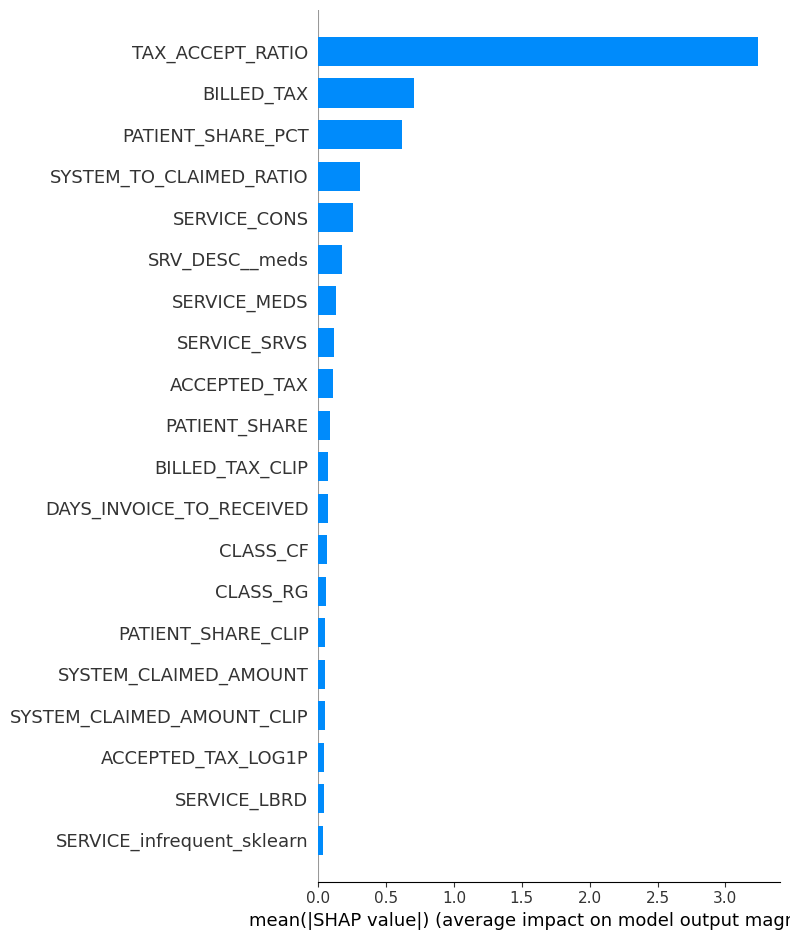

In [ ]:
# SHAP on calibrated pipeline
import shap, scipy.sparse as sp
shap.initjs()

# Used the trained preprocessor and base tree model
pre_fitted = clf.named_steps['pre']
tree_model = pipe_base.named_steps['model']

# Sample manageable slice of validation data
Xv_small = X_valid.sample(min(5000, len(X_valid)), random_state=42)

# Transform with preprocessor
Xv_small_t = pre_fitted.transform(Xv_small)
if sp.issparse(Xv_small_t):
    Xv_small_t = Xv_small_t.tocsr()

# Build feature names properly
feat_names = []
for name, trans, cols in pre.transformers_:
    if name == 'num':
        feat_names.extend(cols)
    elif name == 'cat':
        ohe = trans.named_steps['ohe']
        cats = ohe.get_feature_names_out(cols)
        feat_names.extend(cats)
    elif name.startswith('text_'):
        tfidf = trans.named_steps['tfidf']
        vocab = tfidf.get_feature_names_out()
        col = cols[0]
        feat_names.extend([f"{col}__{w}" for w in vocab])

print("Total feature names:", len(feat_names))
print("First 20 names:", feat_names[:20])

# SHAP explain
explainer = shap.TreeExplainer(tree_model)
sv = explainer.shap_values(Xv_small_t)

shap.summary_plot(sv, Xv_small_t, feature_names=feat_names, plot_type='bar')

Top drivers include TAX_ACCEPT_RATIO, BILLED_TAX, PATIENT_SHARE_PCT, SYSTEM_TO_CLAIMED_RATIO, plus service/text tokens (e.g., SRV_DESC_meds, SERVICE_), ACCEPTED_TAX, PATIENT_SHARE, BILLED_TAX_CLIP, and DAYS_INVOICE_TO_RECEIVED; indicating tax consistency, patient share, and timing cues strongly influence approvals.

##Step 14: Save Artifacts (pipeline + metadata + threshold)

We save the trained pipeline, metadata (features, versions), and chosen threshold to disk. These artifacts will be loaded later by the Flask app or deployment.

In [ ]:
import os, json, joblib, sklearn, xgboost

os.makedirs("artifacts", exist_ok=True)
BEST_THR = 0.5

joblib.dump(clf, "artifacts/claim_approval_pipeline.joblib")

meta = {
  "base_features": BASE_FEATURES,
  "text_cols": TEXT_COLS, "cat_cols": CAT_COLS, "num_cols": NUM_COLS,
  "library_versions": {"sklearn": sklearn.__version__, "xgboost": xgboost.__version__}
}
with open("artifacts/metadata.json","w") as f: json.dump(meta, f, indent=2)
with open("artifacts/threshold.json","w") as f: json.dump({"threshold": float(BEST_THR)}, f, indent=2)

print(os.listdir("artifacts"))

['claim_approval_pipeline.joblib', 'metadata.json', 'threshold.json']


##Step 15: Predict one record

We create a helper to test a single claim record, returning the probability, decision, and top contributing features. This is the same logic used by the Flask app interface.

In [ ]:
import re, numpy as np, pandas as pd, scipy.sparse as sp

def clean_name(n: str) -> str:
    return n.replace("__", " (") + (")" if "__" in n else "")

def _apply_engineering_to_row(row: pd.Series,
                              clip_stats: dict,
                              amt_for_feats: list,
                              eps: float = 1e-9) -> pd.Series:
    # Ratios
    if {'PATIENT_SHARE','CLAIMED_AMOUNT'}.issubset(row.index):
        row['PATIENT_SHARE_PCT'] = np.clip(row['PATIENT_SHARE'] / (row['CLAIMED_AMOUNT'] + eps), 0, 5.0)
    if {'ACCEPTED_TAX','BILLED_TAX'}.issubset(row.index):
        val = row['ACCEPTED_TAX'] / (row['BILLED_TAX'] + eps)
        row['TAX_ACCEPT_RATIO'] = 0.0 if pd.isna(val) else float(np.clip(val, 0, 2.0))
    if {'SYSTEM_CLAIMED_AMOUNT','CLAIMED_AMOUNT'}.issubset(row.index):
        row['SYSTEM_TO_CLAIMED_RATIO'] = np.clip(row['SYSTEM_CLAIMED_AMOUNT'] / (row['CLAIMED_AMOUNT'] + eps), 0, 5.0)

    # Amount features using Train clip stats
    for c in amt_for_feats:
        if c in row.index and c in clip_stats and pd.notna(row[c]):
            s = float(row[c])
            hi = float(clip_stats[c])
            row[f"{c}_CLIP"]      = np.clip(s, None, hi)
            row[f"{c}_LOG1P"]     = np.log1p(np.clip(s, 0, hi))
            row[f"{c}_NEG_FLAG"]  = int(s < 0)
            row[f"{c}_ZERO_FLAG"] = int(s == 0)
        else:
            #ensure columns exist even if raw missing
            row[f"{c}_CLIP"]      = np.nan
            row[f"{c}_LOG1P"]     = np.nan
            row[f"{c}_NEG_FLAG"]  = 0
            row[f"{c}_ZERO_FLAG"] = 0
    return row

def predict_one_pretty(record: dict, top_k=3, threshold=None, use_shap=True):
    # Normalize keys to TRAIN schema
    rec_norm = {re.sub(r"\s+","_", str(k).strip().upper()): v for k, v in record.items()}

    # Handle SRV_DESC / SERVICE_DESC alias
    if 'SERVICE_DESC' in rec_norm and 'SRV_DESC' not in rec_norm and 'SRV_DESC' in BASE_FEATURES:
        rec_norm['SRV_DESC'] = rec_norm.pop('SERVICE_DESC')

    # Create a single-row DF with All expected features as columns
    Xone = pd.DataFrame([{col: np.nan for col in BASE_FEATURES}])
    # Fill with provided raw fields (only if they belong to the schema)
    for k, v in rec_norm.items():
        if k in Xone.columns:
            Xone.at[0, k] = v

    # Engineer per-row features to match training
    row = Xone.iloc[0]
    row = _apply_engineering_to_row(row, clip_stats=clip_stats, amt_for_feats=[c for c in amt_for_feats if c in BASE_FEATURES])
    Xone.iloc[0] = row

    # Predict with calibrated pipeline
    p = float(clf.predict_proba(Xone)[0, 1])
    t = float(BEST_THR if threshold is None else threshold)
    out = {"proba_approved": round(p, 4), "threshold": round(t, 4), "decision": int(p >= t)}

    # SHAP using base tree model explanations
    if use_shap:
        pre_fitted = clf.named_steps['pre']
        Xt = pre_fitted.transform(Xone)
        if sp.issparse(Xt):
            Xt = Xt.tocsr()
        sv1 = explainer.shap_values(Xt)[0]
        idx = np.argsort(np.abs(sv1))[-top_k:][::-1]
        contrib = [{"feature": clean_name(feat_names[j]),
                    "impact": "↑" if sv1[j] > 0 else "↓",
                    "magnitude": round(float(abs(sv1[j])), 3)} for j in idx]
        out["top_contributors"] = contrib

    return out

In [ ]:
#test1
sample_low = {
    "CLAIMED_AMOUNT": 5000,
    "SYSTEM_CLAIMED_AMOUNT": 200,
    "PATIENT_SHARE": 4000,
    "BILLED_TAX": 300,
    "ACCEPTED_TAX": 10,
    "GROSS_CLAIMED_AMOUNT": 5200,
    "DAYS_ADMISSION_TO_EXIT": 5,
    "DAYS_ADMISSION_TO_INVOICE": 30,
    "DAYS_INVOICE_TO_RECEIVED": 90,
    "COUNTRY": "LEB",
    "INSURER": "ARP",
    "CONDITION": "REJECTED",
    "CLASS": "BB",
    "COVER": "BASIC",
    "CURRENCY": "LBP",
    "ADM_TYPE": "INPATIENT",
    "SERVICE": "GENERAL",
    "PRE-AUTHORIZED": "NO",
    "PROD": "GEN",
    "DIAGNOSIS_DESCRIPTION": "unspecified condition",
    "SERVICE_DESC": "general service"
}

predict_one_pretty(sample_low, top_k=3)


/tmp/ipython-input-3660427767.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'LEB' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  Xone.at[0, k] = v
/tmp/ipython-input-3660427767.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ARP' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  Xone.at[0, k] = v
/tmp/ipython-input-3660427767.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'REJECTED' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  Xone.at[0, k] = v
/tmp/ipython-input-3660427767.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pand

{'proba_approved': 0.0119,
 'threshold': 0.5,
 'decision': 0,
 'top_contributors': [{'feature': 'TAX_ACCEPT_RATIO',
   'impact': '↓',
   'magnitude': 2.179},
  {'feature': 'PATIENT_SHARE_PCT', 'impact': '↓', 'magnitude': 1.535},
  {'feature': 'SERVICE_infrequent_sklearn',
   'impact': '↑',
   'magnitude': 0.925}]}

proba_approved=0.0119,, below the 0.50 threshold, decision = not approved or rejected. Biggest downward drivers were TAX_ACCEPT_RATIO and PATIENT_SHARE_PCT, which pulled the score down strongly.

In [ ]:
#test2
sample_high = {
    "CLAIMED_AMOUNT": 300,
    "SYSTEM_CLAIMED_AMOUNT": 280,
    "PATIENT_SHARE": 0,
    "BILLED_TAX": 3,
    "ACCEPTED_TAX": 3,
    "GROSS_CLAIMED_AMOUNT": 305,
    "DAYS_ADMISSION_TO_EXIT": 0,
    "DAYS_ADMISSION_TO_INVOICE": 7,
    "DAYS_INVOICE_TO_RECEIVED": 30,
    "COUNTRY": "LEB",
    "INSURER": "ARP",
    "CONDITION": "ACCEPTED",
    "CLASS": "AB",
    "COVER": "STANDARD",
    "CURRENCY": "LBP",
    "ADM_TYPE": "OUTPATIENT",
    "SERVICE": "GENERAL",
    "PRE-AUTHORIZED": "YES",
    "PROD": "GEN",
    "DIAGNOSIS_DESCRIPTION": "routine check up",
    "SRV_DESC": "consultation"
}

predict_one_pretty(sample_high, top_k=3)

/tmp/ipython-input-3660427767.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'LEB' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  Xone.at[0, k] = v
/tmp/ipython-input-3660427767.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ARP' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  Xone.at[0, k] = v
/tmp/ipython-input-3660427767.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ACCEPTED' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  Xone.at[0, k] = v
/tmp/ipython-input-3660427767.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pand

{'proba_approved': 0.98,
 'threshold': 0.5,
 'decision': 1,
 'top_contributors': [{'feature': 'TAX_ACCEPT_RATIO',
   'impact': '↑',
   'magnitude': 3.866},
  {'feature': 'BILLED_TAX', 'impact': '↓', 'magnitude': 0.489},
  {'feature': 'SERVICE_infrequent_sklearn',
   'impact': '↑',
   'magnitude': 0.393}]}

The model predicted a proba_approved = 0.98 (approval probability = 98%), above the 0.50 threshold so decision = approved.

The strongest positive driver was high tax acceptance, with additional support from the service category, while billed tax slightly reduced the score.